<a href="https://colab.research.google.com/github/ImajiPietersz/FYP/blob/main/ICA_improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.decomposition import FastICA, PCA
from scipy.io import wavfile
import pandas as pd
import seaborn as sns

# Apply adaptive filtering on S_ica
from scipy.signal import lfilter

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Set step size parameter mu for adaptive filtering
mu=0.001
DATASET_PATH = '/content/drive/MyDrive/FYP18-machine-vibration-source-separation/ LoRaWAN dataset/machine_2_with_Noise_sensor1.csv'
IMP_COL = ['XOAVelocity', 'XPeakmg', 'XRMSmg', 'XKurtosis',
       'XCrestFactor', 'XSkewness', 'XDeviation', 'XPeaktoPeakDisplacement',
       'YOAVelocity', 'YPeakmg', 'YRMSmg', 'ZOAVelocity', 'ZPeakmg', 'ZRMSmg', 'target']
X_COL = ['XOAVelocity', 'XPeakmg', 'XRMSmg', 'XKurtosis',
       'XCrestFactor', 'XSkewness', 'XDeviation', 'XPeaktoPeakDisplacement',
       'YOAVelocity', 'YPeakmg', 'YRMSmg', 'ZOAVelocity', 'ZPeakmg', 'ZRMSmg']
TAR_COL = 'target'

In [8]:
df = pd.read_csv(DATASET_PATH)[IMP_COL]

In [ ]:
df

,XOAVelocity,XPeakmg,XRMSmg,XKurtosis,XCrestFactor,XSkewness,XDeviation,XPeaktoPeakDisplacement,YOAVelocity,YPeakmg,YRMSmg,ZOAVelocity,ZPeakmg,ZRMSmg,target
0,7,18,13,-5,38,-4,8,1,8,11,8,20,156,111,0
1,67,183,130,22,197,8,531,6,38,137,97,85,390,276,0
2,20,48,34,-3,203,1,204,2,18,36,26,63,216,153,0
3,218,305,216,-36,132,-5,291,23,232,306,217,132,117,83,0
4,9,18,13,3,1039,-1,8,1,9,12,9,16,107,76,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2179,36,50,36,9,831,3,8,3,39,52,37,70,302,214,0
2180,21,41,29,27,1826,0,137,2,19,43,31,82,182,129,1
2181,313,243,172,-22,296,2,234,38,158,137,97,344,183,130,1
2182,30,45,32,8,1116,-8,9,3,45,60,43,65,305,216,1


In [21]:
x_data, label = np.asarray(df[X_COL]), np.asarray(df[TAR_COL])

In [22]:
value,counts = np.unique(label,return_counts=True)

In [23]:
x = x_data[label == 1]
x_noisy = x_data[label == 0]

In [ ]:
# if counts[0] < counts[1]:
#   x = x_data[label == 1]
#   x_noisy = x_data[label == 0]
#   #generating a random set of indices from the array x_data values that correspond to a particular label.
#   #generating additional indices to balance out the number of instances in each label.
#   additional_ind = np.random.choice(x_data[label == 0].shape[0],counts[1]-counts[0],replace=False)
#   x_noisy = np.concatenate([x_noisy,x_data[label == 0][additional_ind]])

# else:
#   x = x_data[label == 1]
#   x_noisy = x_data[label == 0]
#   additional_ind = np.random.choice(x_data[label == 1].shape[0],counts[0]-counts[1],replace=False)
#   x = np.concatenate([x,x_data[label == 1][additional_ind]])

In [12]:
x.shape,x_noisy.shape

((1346, 14), (838, 14))

In [24]:
# Apply ICA on x_noisy
ica=FastICA(n_components=2)   # Create an ICA model with two components
S_ica=ica.fit_transform(x_noisy)   # Fit and transform x_noisy into two independent components

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


In [25]:
# Get estimated mixing matrix A_ica
A_ica=ica.mixing_

In [26]:
def adaptive_filter(x ,d ,mu):    #x->x_noisy, d-> x
    # Implement least mean square (LMS) algorithm for adaptive filtering
    # x is input signal ,d is desired signal ,mu is step size parameter
    # Returns y as output signal and e as error signal

    # Get length of input signal n
    n=len(x)

    # Initialize weight vector w with zeros
    w=np.zeros(n)

    # Initialize output vector y with zeros
    y=np.zeros(n)

    # Initialize error vector e with zeros
    e=np.zeros(n)

    # Loop over each sample in x
    for i in range(n):
        # Get i-th sample of x as x_i
        x_i=x[i]

        # Compute output y_i as w dot x_i
        y_i=w.dot(x_i)

        # Store y_i in output vector y at index i
        y[i]=y_i[i]

        # Compute error e_i as d_i minus y_i
        e_i=d[i]-y_i

        # Store e_i in error vector e at index i
        e[i]=e_i[i]

        # Update weight vector w as w plus mu times e_i times x_i
        w=w+mu*e_i*x_i

    return y,e

In [ ]:

# Apply adaptive filtering on first component of S_ica using second component as desired signal
y1,e1= adaptive_filter(S_ica[:,0] ,S_ica[:,1] ,mu)
# Apply adaptive filtering on second component of S_ica using first component as desired signal
y2,e2=adaptive_filter(S_ica[:,1] ,S_ica[:,0] ,mu)

In [ ]:
# Concatenate filtered components into matrix Y
Y=np.c_[y1,y2]

# Reconstruct denoised signal x_denoised by multiplying Y with inverse of A_ica
x_denoised=Y.dot(np.linalg.pinv(A_ica))

In [28]:
# arr= []
# for value in x_denoised:
#   arr.append(value[0])

In [29]:
li1 = []
for i in x:
  li1.append(i[0])

In [30]:
li2 = []
for i in x_noisy:
  li2.append(i[0])

mu = 0.0005


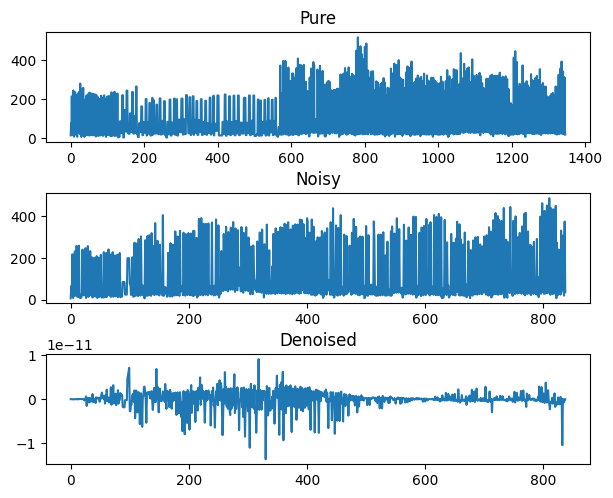

mu = 0.001


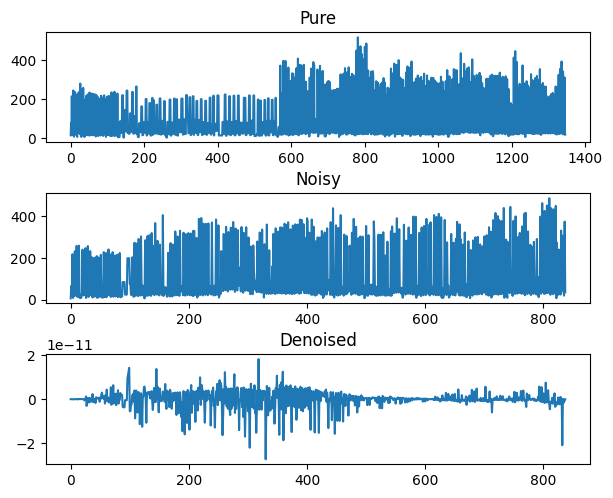

mu = 0.005


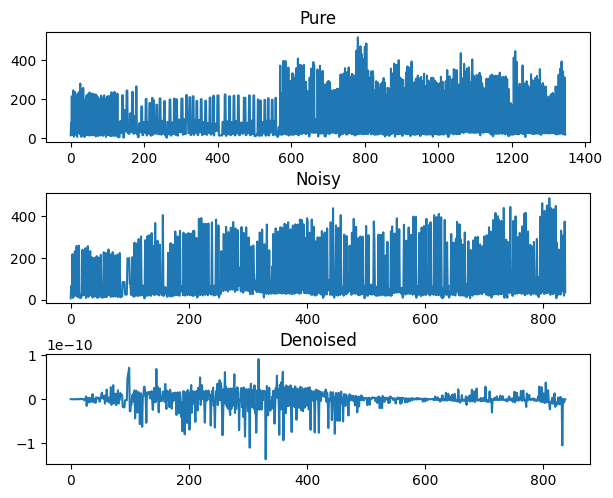

mu = 0.009


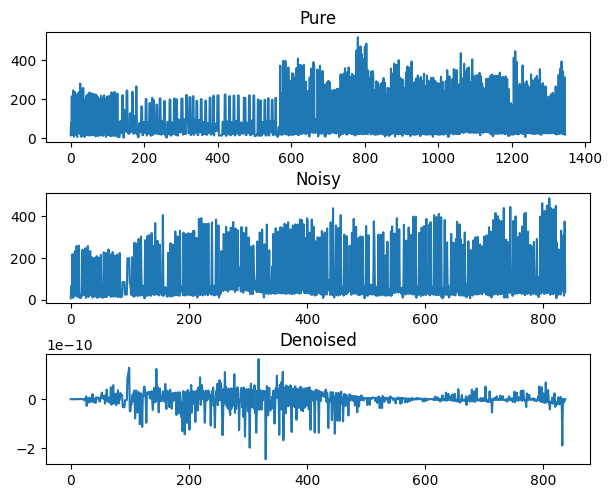

mu = 0.01


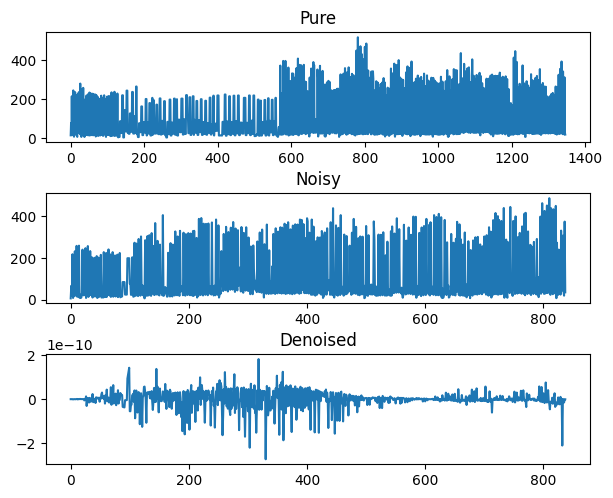

mu = 0.09


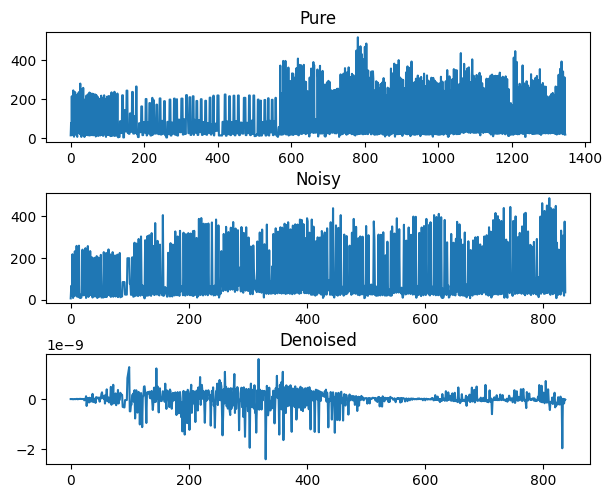

mu = 0.1


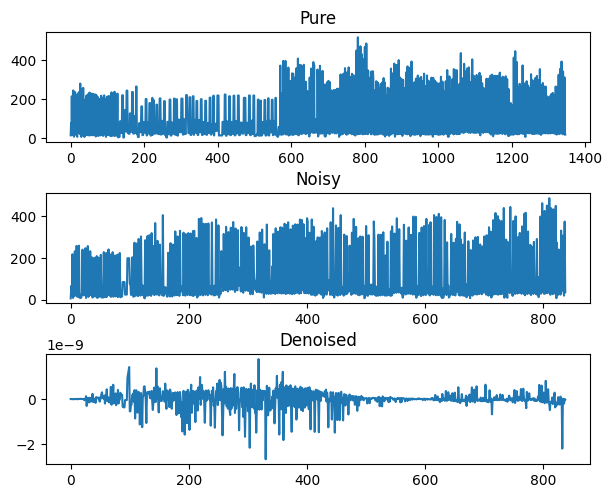

In [35]:


Mu=[0.0005,0.001,0.005, 0.009, 0.01, 0.09, 0.1]
for mu in Mu:
  print("mu = "+ str(mu))
  # Apply adaptive filtering on first component of S_ica using second component as desired signal
  y1,e1= adaptive_filter(S_ica[:,0] ,S_ica[:,1] ,mu)
# Apply adaptive filtering on second component of S_ica using first component as desired signal
  y2,e2=adaptive_filter(S_ica[:,1] ,S_ica[:,0] ,mu)

# Concatenate filtered components into matrix Y
  Y=np.c_[y1,y2]

# Reconstruct denoised signal x_denoised by multiplying Y with inverse of A_ica
  x_denoised=Y.dot(np.linalg.pinv(A_ica))

  arr= []
  for value in x_denoised:
    arr.append(value[0])



# Plot results

  plt.figure()

  models=[li1,li2,arr]
  names=['Pure','Noisy','Denoised']

  for ii,(model,name) in enumerate(zip(models,names),1):
    plt.subplot(3,1,ii)
    plt.title(name)
    plt.plot(model)

  plt.subplots_adjust(0.09,0.04,0.94,0.94,0.26,0.46)
  plt.show()

